# Monte Carlo simulation of a stock portfolio

In [79]:
import pandas as pd
import numpy as np 
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime as dt 
from pandas_datareader import data as pdr 
import yfinance as yfin

*Get data and define portfolio weights*

In [13]:
yfin.pdr_override()

def get_data(stocks, start, end):
    stockData = pdr.get_data_yahoo(stocks,start,end)
    stockData = stockData['Close']
    returns = stockData.pct_change() #daily change
    meanReturns = returns.mean() 
    covMatrix = returns.cov()
    return meanReturns, covMatrix

stocks = ['NVDA', 'META','AAPL', 'NFLX', 'AMZN','CRWD','GOOGL','ADBE']
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=300)

meanReturns, covMatrix = get_data(stocks, startDate, endDate)

weights = np.random.random(len(meanReturns))
weights /= np.sum(weights)

[*********************100%%**********************]  8 of 8 completed

Ticker
AAPL    -0.000192
ADBE    -0.000175
AMZN     0.001805
CRWD     0.003920
GOOGL    0.001629
META     0.002340
NFLX     0.001742
NVDA     0.003574
dtype: float64


*Monte Carlo simulation*

* We assume daily returns follow a multivariate normal distribution: $R_t \sim MVN(\mu,\Sigma)$
* We use Cholesky decomposition to determine the lower triangular matrix, and simulate daily changes accordingly

Mean $11870.03
Median $11797.03
Minimum $8183.83
Maximum $16996.62


<function matplotlib.pyplot.show(close=None, block=None)>

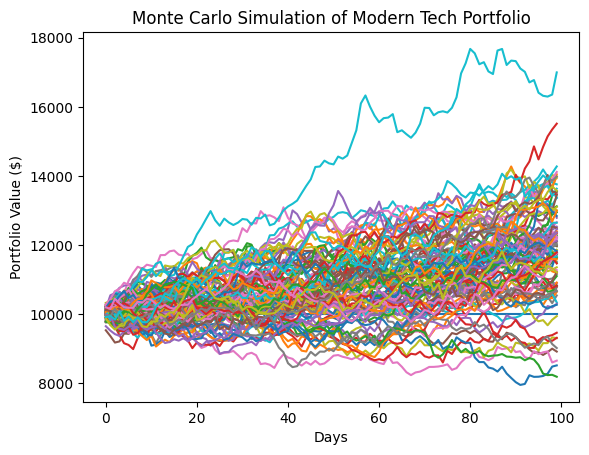

In [31]:
mc_sims = 100 
T = 100 # timeframe in days

meanM = np.full(shape=(T,len(weights)),fill_value=meanReturns)
meanM = meanM.T

portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)

initialPortfolio = 10000

portfolio_sims[:,0] = initialPortfolio

for m in range(1,mc_sims):
    Z = np.random.normal(size = (T,len(weights)))
    L = np.linalg.cholesky(covMatrix)
    dailyReturns = meanM + np.inner(L,Z)
    portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio

mean = np.mean(portfolio_sims[-1,:])
med = np.median(portfolio_sims[-1,:])
min = np.min(portfolio_sims[-1,:])
max = np.max(portfolio_sims[-1,:])

print('Mean ${}'.format(round(mean,2)))
print('Median ${}'.format(round(med,2)))
print('Minimum ${}'.format(round(min,2)))
print('Maximum ${}'.format(round(max,2)))

plt.plot(portfolio_sims)
plt.ylabel("Portfolio Value ($)")
plt.xlabel("Days")
plt.title("Monte Carlo Simulation of Modern Tech Portfolio")
plt.show

# Monte Carlo simulation with VaR and CVaR

In [32]:
### DEFINE VaR and CVaR FUNCTIONS ###

def mcVaR(returns,alpha=5):
    """
    Input: pandas series of returns
    Output: percentile on returns distribution to a given confidence level
    """

    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha) 
    
    else:
        raise TypeError("Expected pandas data series")
    
def mcCVaR(returns,alpha=5):
    """
    Input: pandas series of returns
    Output: CVaR to a given confidence level (default 95%)
    """

    if isinstance(returns, pd.Series):
        belowVaR = returns <= mcVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()
    
    else:
        raise TypeError("Expected pandas data series")

VaR $711.44
CVaR $1345.09


<function matplotlib.pyplot.show(close=None, block=None)>

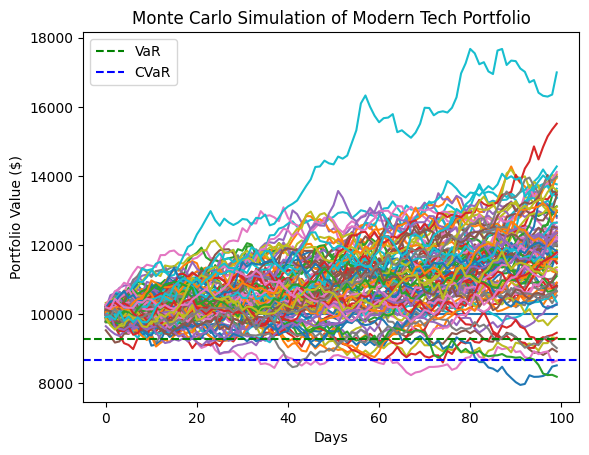

In [42]:
portResults = pd.Series(portfolio_sims[-1,:]) # last element of simulation

VaR = initialPortfolio - mcVaR(portResults,alpha=5)
CVaR = initialPortfolio - mcCVaR(portResults,alpha=5)

print('VaR ${}'.format(round(VaR,2))) # our 5th percentile below the initial value
print('CVaR ${}'.format(round(CVaR,2))) # expected value below the 5th percentile - how much we expect to lose

plt.plot(portfolio_sims)
plt.axhline(y=initialPortfolio - VaR, linestyle = '--', color='g', label="VaR")
plt.axhline(y=initialPortfolio - CVaR, linestyle = '--', color='b',label="CVaR")
plt.legend()
plt.ylabel("Portfolio Value ($)")
plt.xlabel("Days")
plt.title("Monte Carlo Simulation of Modern Tech Portfolio")
plt.show

# Monte Carlo Simulation for Option Pricing

* Risk neutral and continuous time

In [115]:
S = 101.15 # stock price
K = 98.01 # strike price
vol = 0.0991 # volatility 
r = 0.05 #rf 
N = 10 #no of time steps 
M = 1000 #no simulations

market_value = 4.24 # market price of option 
T = ((dt.date(2024,7,7)-dt.date.today()).days+1)/365
print(T)

0.16164383561643836


In [102]:
# Set up parameters
deltat = T/N 
nudt = (r-0.5*vol**2)*deltat 
volsdt = vol*np.sqrt(deltat)
lnS = np.log(S)

# MC Method
Z = np.random.normal(size=(N,M))
delta_lnSt = nudt + volsdt*Z 
lnSt = lnS + np.cumsum(delta_lnSt, axis=0)
lnSt = np.concatenate((np.full(shape=(1,M), fill_value = lnS), lnSt))

# E and SE
ST = np.exp(lnSt)
CT = np.maximum(0, ST-K)
C0 = np.exp(-r*T)*np.sum(CT[-1])/M  

sigma = np.sqrt(np.sum(CT[-1]-C0)**2 / (M-1))
SE = sigma/np.sqrt(M)

print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,2)))

Call value is $4.25 with SE +/- 0.03


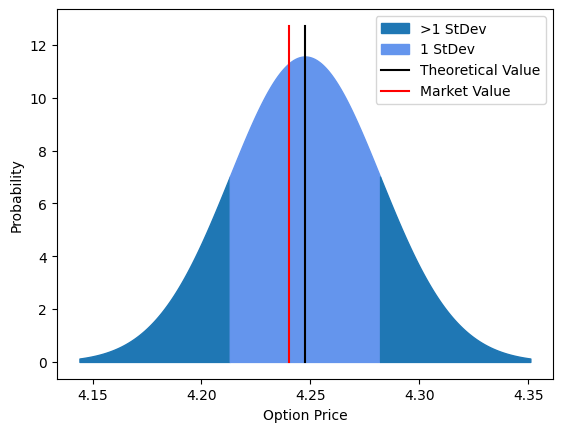

In [118]:
# Visualize Results

x1 = np.linspace(C0-3*SE,C0-1*SE,100)
x2 = np.linspace(C0-1*SE,C0+1*SE,100)
x3 = np.linspace(C0+1*SE,C0+3*SE,100)

s1 = stats.norm.pdf(x1,C0,SE)
s2 = stats.norm.pdf(x2,C0,SE)
s3 = stats.norm.pdf(x3,C0,SE)

plt.fill_between(x1, s1, color='tab:blue',label='>1 StDev')
plt.fill_between(x2, s2, color='cornflowerblue',label='1 StDev')
plt.fill_between(x3, s3, color='tab:blue')

plt.plot([C0,C0],[0,np.max(s2)*1.1],'k',label='Theoretical Value')
plt.plot([market_value,market_value],[0,np.max(s2)*1.1],'r',label='Market Value')

plt.ylabel("Probability")
plt.xlabel("Option Price")
plt.legend()
plt.show()
